In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

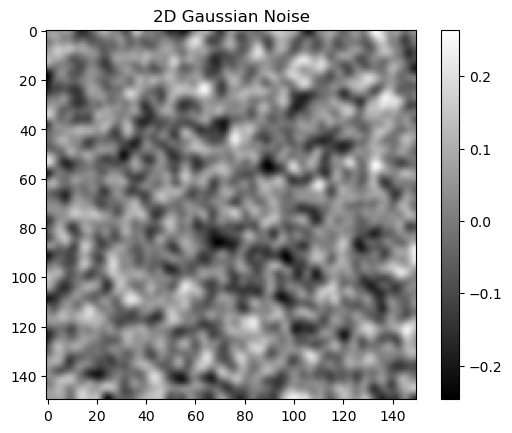

In [15]:
mean = 0     # Mean of the distribution
std_dev = 0.5  # Standard deviation of the distribution


gaussian_noise = np.random.normal(mean, std_dev, size=(150, 150))
smoothed_noise = gaussian_filter(gaussian_noise, sigma=2)

# Plotting the 2D Gaussian noise
plt.imshow(smoothed_noise, cmap='gray')
plt.title('2D Gaussian Noise')
plt.colorbar()
plt.show()